### Train ETH data to CNN generative network

In [ ]:
!pip install -U "ray[data,train,tune,serve]"

In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
import os
os.environ["PL_TORCH_DISTRIBUTED_BACKEND"] = "gloo"

if torch.cuda.device_count():
    device = 'cuda'
    use_gpu = True
    print('Good to go')
else:
    device = 'cpu'
    use_gpu = False
    print('Using cpu')

Good to go


## Read 9-9-9 grid data

In [3]:
from ReadData import ReadCurrentAndField_CNN,add_gaussian_noise
import glob
import os 

# TODO zhoujing edit this Data loading 
# print(os.getcwd())s
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
train_file_num= 1000
#data = ReadFolder(foldername,filepattern)
current,data = ReadCurrentAndField_CNN (foldername,filepattern,train_file_num)

fileList = glob.glob(foldername+filepattern)
position = data[:,0:3,2:19:2,2:19:2,2:19:2]
Bfield = data[:,3:,2:19:2,2:19:2,2:19:2]
noise = 0.00
grid_size=position.shape[2]
# print(fileList)
print(data.shape)
print('current shape', current.shape)
print('Bfield shape', Bfield.shape)
print('train:gird :',grid_size)
current = add_gaussian_noise(current,noise=noise)
Bfield = add_gaussian_noise(Bfield,noise=noise)

torch.Size([1000, 6, 21, 21, 21])
current shape torch.Size([1000, 12])
Bfield shape torch.Size([1000, 3, 9, 9, 9])
train:gird : 9


## SRBF 9-9-9 -> 16-16-16

In [4]:
from utils import interpolation_data
eps = 6
Bfield_interp=interpolation_data(data,position,Bfield,eps,device=device)

print(Bfield_interp.shape)

torch.Size([1000, 3, 16, 16, 16])


In [5]:
from Neural_network import eMNS_Dataset
from Training_loop_v2 import train_GM
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer,TorchConfig
from ray.tune.tuner import Tuner
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import ray
import os
os.environ["PL_TORCH_DISTRIBUTED_BACKEND"] = "gloo"
# construct dataset
dataset = eMNS_Dataset(
    x=current,
    y=Bfield_interp
)
# split the dataset to train, validation, test
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [0.85,0.1,0.05])

print(train_set.indices)
print(train_set.dataset.x[0])

# normailzation
extremes = dataset.train_norm(train_indices = train_set.indices)
print(train_set.dataset.x[train_set.indices[0]])
print('++++++====')
for index,(x,y) in enumerate(train_set):
    print('index=',index,'x=',x)

for index,(x,y) in enumerate(valid_set):
    print('index=',index,'x=',x)

for index,(x,y) in enumerate(test_set):
    print('index=',index,'x=',x)   


2024-04-11 21:32:43,795	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-11 21:32:43,908	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


[12, 849, 919, 494, 445, 784, 25, 732, 813, 537, 74, 86, 965, 957, 888, 219, 419, 797, 353, 512, 887, 140, 348, 959, 154, 161, 498, 57, 733, 792, 927, 576, 598, 756, 407, 386, 364, 195, 356, 316, 223, 69, 968, 583, 324, 37, 481, 710, 789, 759, 129, 522, 638, 23, 781, 936, 661, 619, 216, 44, 391, 52, 15, 446, 586, 689, 423, 855, 2, 247, 571, 709, 617, 314, 916, 839, 297, 226, 579, 34, 601, 79, 48, 898, 609, 321, 289, 77, 505, 270, 620, 972, 68, 275, 917, 514, 774, 127, 925, 741, 441, 215, 584, 207, 747, 182, 823, 189, 151, 302, 147, 132, 602, 970, 914, 947, 253, 206, 567, 480, 43, 365, 397, 977, 923, 554, 424, 288, 676, 742, 491, 298, 177, 96, 248, 158, 830, 762, 706, 70, 457, 907, 557, 261, 479, 836, 755, 317, 354, 716, 256, 509, 293, 243, 166, 892, 452, 819, 244, 435, 799, 523, 637, 860, 169, 406, 982, 42, 631, 876, 440, 283, 649, 737, 525, 360, 296, 837, 726, 67, 521, 114, 769, 829, 984, 202, 518, 458, 90, 88, 699, 87, 94, 221, 644, 110, 739, 574, 711, 991, 682, 251, 309, 128, 695, 5

### Tune hyperparameters

In [6]:
from Neural_network import eMNS_Dataset
from Training_loop_v2 import train_GM
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer,TorchConfig
from ray.tune.tuner import Tuner
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import ray
import os
os.environ["PL_TORCH_DISTRIBUTED_BACKEND"] = "gloo"
# construct dataset
dataset = eMNS_Dataset(
    x=current,
    y=Bfield_interp
)
# split the dataset to train, validation, test
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [0.85,0.1,0.05])


# normailzation
extremes = dataset.train_norm(train_indices = train_set.indices)

tune_schedule = ASHAScheduler(
        metric="rmse_val", # metric to optimize. This metric should be reported with tune.report()
        mode="min",
        max_t=350,
        grace_period=350, # minimum stop epoch
        reduction_factor=2,
    )
param_space = {
    "scaling_config": ScalingConfig(
        num_workers = 1,
        use_gpu = use_gpu,
        resources_per_worker = {"CPU":4, "GPU":0}
    ),
    # You can even grid search various datasets in Tune.
    # "datasets": {
    #     "train": tune.grid_search(
    #         [ds1, ds2]
    #     ),
    # },
    "train_loop_config": {
                'epochs': 1,
                'lr_max': tune.grid_search([1e-3,1e-4,5e-4]),
                'lr_min': tune.grid_search([1e-5,2.5e-6,2.5e-7]),
                'batch_size': 8,
                'L2_norm'   : 0,
                'verbose': False,
                'DF'     : False,
                'schedule': [],
                'grid_space': 16**3,
                'learning_rate_decay': 0.5,
                'skip_spacing': 2,
                'num_repeat'  : 1,
                'num_block'   : 3,
                'maxB'        : extremes[2],
                'minB'        : extremes[3],
                'train_set'   : train_set,
                'valid_set'   : valid_set,
                'num_input'   : 12,
            }

}

train_percents = np.arange(1.0,1.01,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
mse_history_end = np.zeros(len(train_percents))
mse_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))

################################################
# Train the neural network
################################################

train_loop_config = {
                'epochs': 350,
                'lr_max': 5e-4,
                'lr_min': 2.5e-6,
                'batch_size': 8,
                'L2_norm'   : 0,
                'verbose': False,
                'DF'     : False,
                'schedule': [],
                'grid_space': 16**3,
                'learning_rate_decay': 0.5,
                'skip_spacing': 2,
                'num_repeat'  : 1,
                'num_block'   : 3,
                'maxB'        : extremes[2],
                'minB'        : extremes[3],
                'device'      : device,
                'train_set'   : train_set,
                'valid_set'   : valid_set,
                'num_input'   : 12,
                # You can even grid search various datasets in Tune.
                # "datasets": tune.grid_search(
                #         [ds1, ds2]
                #     ),
}

scaling_config = ScalingConfig(
    num_workers = 1,
    use_gpu = use_gpu,
    # resources_per_worker = {"CPU":4, "GPU":1}
)

run_config = RunConfig(checkpoint_config=CheckpointConfig(num_to_keep=1))#,storage_path='D:\Qubot\Trained_model', 
                       #name='EMS_CNN_'+'s_'+str(train_loop_config['skip_spacing'])+'r_'+str(train_loop_config['num_repeat'])+'b_'+str(train_loop_config['num_block']) )
#
# def train_loop_per_worker(params):
#     train_GM(train_set=train_set, valid_set=valid_set,  device=device, config=params)
torch_config = TorchConfig(backend="gloo")
trainer = TorchTrainer(
    train_loop_per_worker = train_GM,
    train_loop_config = train_loop_config,
    torch_config=torch_config,
    scaling_config = scaling_config,
    run_config = run_config,

)
# train the model
result = trainer.fit()
#----------------------------------------------
# tuner = tune.Tuner(
#     trainer,
#     param_space = param_space,
#     tune_config =tune.TuneConfig(
#         scheduler=tune_schedule,
#         num_samples=1, # number of samples of hyperparameter space
#     ),
#     # run_config = RunConfig(checkpoint_config=CheckpointConfig(num_to_keep=2),storage_path="/home/qubot/ray_results", name="test_experiment"),
                            # checkpoint_score_attribute='rmse_val', checkpoint_score_order='min
# )
# # tune the model    
# results = tuner.fit()

(TorchTrainer pid=27072) Started distributed worker processes: 
(TorchTrainer pid=27072) - (ip=127.0.0.1, pid=51256) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=51256) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=51256) [W socket.cpp:697] [c10d] The client socket has failed to connect to [Qubot]:54915 (system error: 10049 - �����������У�������ĵ�ַ��Ч��).


(RayTrainWorker pid=51256) Epoch 0, Iteration 107, loss = 0.0766, l1 loss=0.0559, grad loss=0.0207
(RayTrainWorker pid=51256) Got rmse 6.689171314239502


(RayTrainWorker pid=51256) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/14032/ray_results/TorchTrainer_2024-04-11_21-32-55/TorchTrainer_068b2_00000_0_2024-04-11_21-33-04/checkpoint_000000)


(RayTrainWorker pid=51256) Got rmse 6.6314239501953125
(RayTrainWorker pid=51256) 
(RayTrainWorker pid=51256) Epoch 1, Iteration 214, loss = 0.0568, l1 loss=0.0403, grad loss=0.0166
(RayTrainWorker pid=51256) Got rmse 3.7225966453552246
(RayTrainWorker pid=51256) Got rmse 3.7974634170532227
(RayTrainWorker pid=51256) 
(RayTrainWorker pid=51256) Epoch 2, Iteration 321, loss = 0.0390, l1 loss=0.0268, grad loss=0.0123
(RayTrainWorker pid=51256) Got rmse 3.488633155822754
(RayTrainWorker pid=51256) Got rmse 3.558692216873169
(RayTrainWorker pid=51256) 
(RayTrainWorker pid=51256) Epoch 3, Iteration 428, loss = 0.0464, l1 loss=0.0317, grad loss=0.0147
(RayTrainWorker pid=51256) Got rmse 3.658651351928711
(RayTrainWorker pid=51256) Got rmse 3.61558198928833
(RayTrainWorker pid=51256) 
(RayTrainWorker pid=51256) Epoch 4, Iteration 535, loss = 0.0461, l1 loss=0.0340, grad loss=0.0121
(RayTrainWorker pid=51256) Got rmse 3.0598061084747314
(RayTrainWorker pid=51256) Got rmse 3.2318031787872314
(R

(RayTrainWorker pid=51256) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/14032/ray_results/TorchTrainer_2024-04-11_21-32-55/TorchTrainer_068b2_00000_0_2024-04-11_21-33-04/checkpoint_000001)
2024-04-11 21:44:13,947	INFO tune.py:1042 -- Total run time: 669.13 seconds (667.91 seconds for the tuning loop).


Result(
  metrics={'rmse_val': 0.1833595484495163, 'rmse_train': 0.10732170194387436, 'loss': 0.002603692002594471},
  path='C:/Users/14032/ray_results/TorchTrainer_2024-04-11_21-32-55/TorchTrainer_068b2_00000_0_2024-04-11_21-33-04',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=C:/Users/14032/ray_results/TorchTrainer_2024-04-11_21-32-55/TorchTrainer_068b2_00000_0_2024-04-11_21-33-04/checkpoint_000001)
)


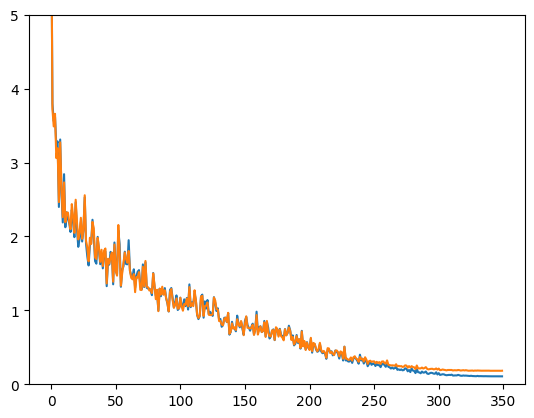

In [7]:
from utils import plot_ray_results
print(result)

plot_ray_results(result, metrics_names=['rmse_train','rmse_val'],ylim=[0,5])

In [ ]:
best_result = results.get_best_result(metric='rmse_val',mode='min')
print(best_result)

In [ ]:
from utils import plot_ray_results
plot_ray_results(best_result, metrics_names=['rmse_train','rmse_val'])

In [ ]:
!tensorboard --logdir=~/ray_results

Got rmse 0.18645644187927246
rmse for test set: 0.1865mT
 mse for test set: 0.0348mT
  R2 for test set: 1.0000
torch.Size([1, 12])
+++++++++++++++++++
torch.Size([12])
plot sample rmse: 0.1547mT


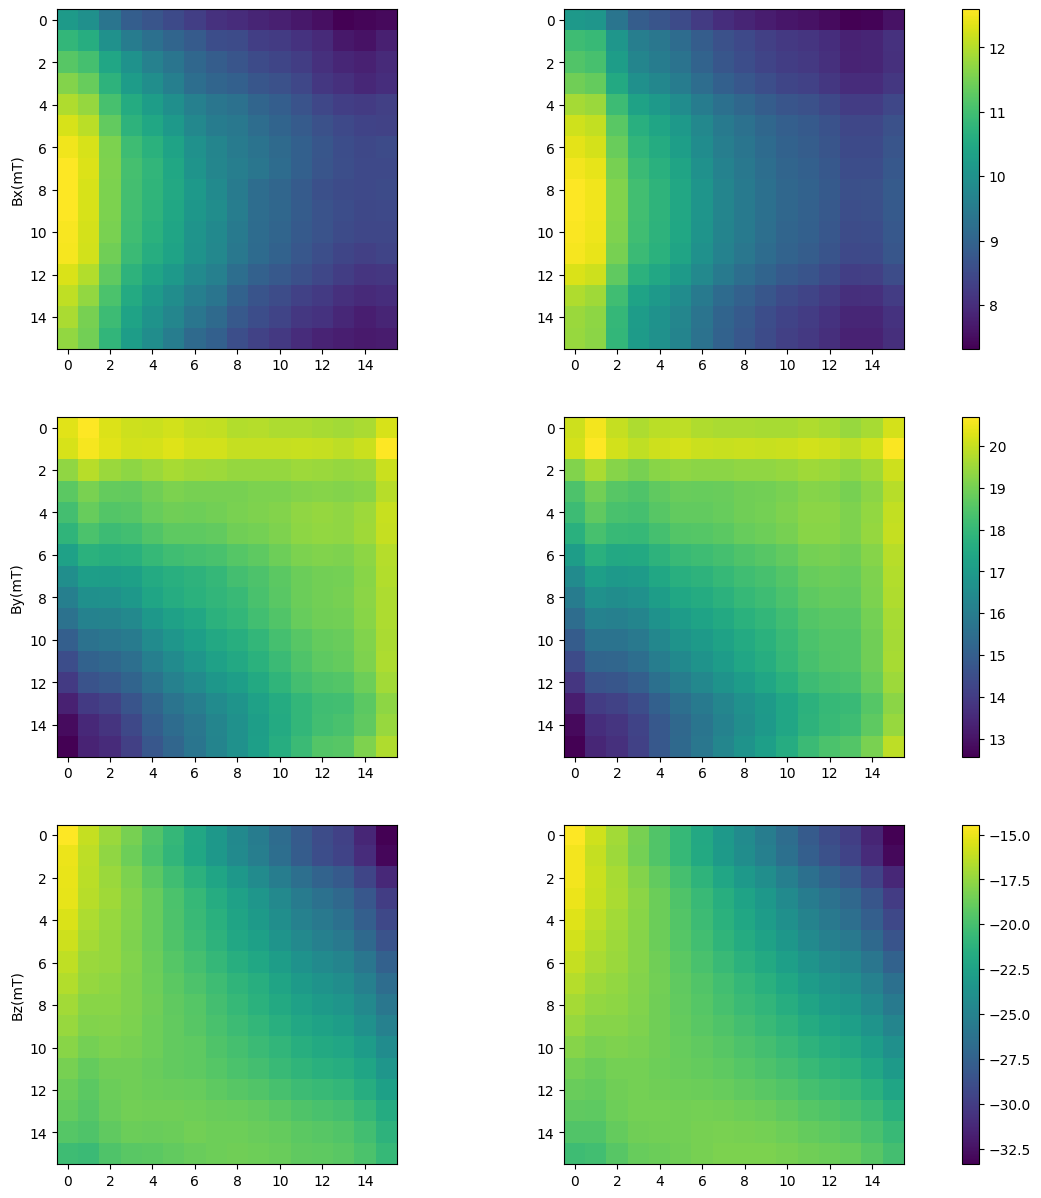

In [8]:

from utils import estimate_test_set 
test_estimator = estimate_test_set(result.checkpoint, test_set, train_loop_config)
test_estimator.fit()
test_estimator.peek_z(3)

In [9]:
from utils import model_output
model_Bfield= model_output(result.checkpoint,train_loop_config)
my_current= torch.tensor(np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,-0.15,0.45,0.53,0,0.32]))
position=np.array([8,8,8])
y=model_Bfield.outputB(my_current,position)

print(y.shape)
print(y)

torch.Size([3])
tensor([-2.6753, -5.4233,  2.0564], device='cuda:0', grad_fn=<SelectBackward0>)


torch.Size([16])
torch.Size([3, 16, 16, 16])
torch.Size([3, 16, 16, 16])


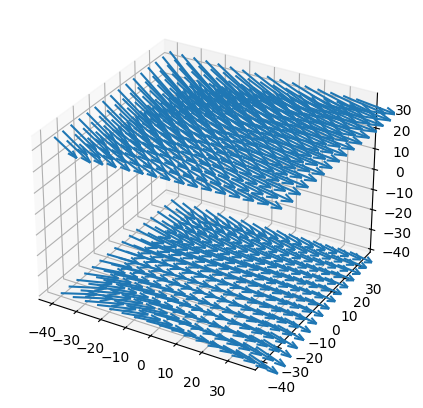

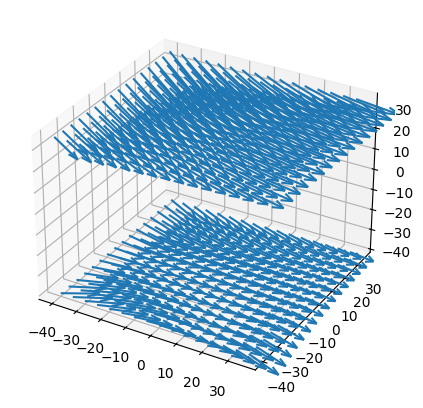

In [10]:
test_estimator.peek_3D(length=0.6)

## Interpolation using SRBF on grids and estimate RMSE

In [ ]:
from utils import check_rmse_interp_CNN
centers_p = data[0,:,2:18:2,2:18:2,2:18:2]
samples_p = data[0,:,3:18:2,3:18:2,3:18:2]
samples_y_train = data[train_set.indices,3:,3:17:2,3:17:2,3:17:2]
samples_y_valid = data[valid_set.indices,3:,3:17:2,3:17:2,3:17:2]
samples_y_test = data[test_set.indices,3:,3:17:2,3:17:2,3:17:2]

interp_estimator = check_rmse_interp_CNN(result.checkpoint,train_loop_config)
rmse_train, mse_train, R2_train = interp_estimator.cnn_SRBF(train_set,centers_p,samples_p,samples_y_train, device = device, DF=False, maxB=extremes[2],minB=extremes[3],eps=0.2)

# rmse_train, mse_train, R2_train=check_rmse_interp_CNN(train_set,centers_p,samples_p,samples_y_train,result.checkpoint, device = device, DF=False, maxB=[],minB=[],eps=0.2)
# print('train_set interp : ','rmse = ',rmse_train)
# rmse_valid, mse_valid, R2_valid=check_rmse_interp_CNN(valid_set,centers_p,samples_p,samples_y_valid,result.checkpoint, device = device, DF=False, maxB=[],minB=[],eps=0.2)
# print('train_set interp : ','rmse = ',rmse_valid)
# rmse_test, mse_test, R2_test=check_rmse_interp_CNN(test_set,centers_p,samples_p,samples_y_test,result.checkpoint, device = device, DF=False, maxB=[],minB=[],eps=0.2)
# print('train_set interp : ','rmse = ',rmse_test)

# optimize current

In [21]:
from scipy.optimize import minimize
import numpy as np
from utils import model_output
import torch.nn.functional as F 

position=np.array([8,8,8])
my_current= np.array([0.1,0.1,0.1,0.1,-0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
# my_current= torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]))

Bgoal=np.array([10, -5,  -10])

def fun(x):
    position=np.array([8,8,8])
    lambda1=0.1
    lambda2=0.2
    model_Bfield= model_output(result.checkpoint,train_loop_config)
    y=model_Bfield.outputB(torch.tensor(x),position)
    y=y.to(device='cpu')
    print(y)
    y=y.detach().numpy()
    loss= ((y-Bgoal)*(y-Bgoal)).sum()+lambda1*(x*x).sum()
    # loss=(x*x).sum()
    return loss

loss=fun(my_current)
# print(loss.size)
print(loss)

#step 1 : import trainded model as a functionty1``
#step 2 : using minimize function to optimize current
# x0=np.array([2])

options = {"disp":True,"maxiter":5000,"xatol":1e-8}
res = minimize(fun,my_current,method='nelder-mead',options=options)

print(res)
print(res.x)

position=np.array([8,8,8])
model_Bfield= model_output(result.checkpoint,train_loop_config)
y=model_Bfield.outputB(torch.tensor(res.x),position)

print('optimitzed field',y)


tensor([ 1.2595,  2.0619, -1.2843], grad_fn=<ToCopyBackward0>)
202.2417419695784
tensor([ 1.2595,  2.0619, -1.2843], grad_fn=<ToCopyBackward0>)
tensor([ 1.3152,  2.0620, -1.2444], grad_fn=<ToCopyBackward0>)
tensor([ 1.2873,  2.1071, -1.2476], grad_fn=<ToCopyBackward0>)
tensor([ 1.2351,  2.1073, -1.2472], grad_fn=<ToCopyBackward0>)
tensor([ 1.2068,  2.0622, -1.2468], grad_fn=<ToCopyBackward0>)
tensor([ 1.2869,  2.1080, -1.3216], grad_fn=<ToCopyBackward0>)
tensor([ 1.2877,  2.0162, -1.2468], grad_fn=<ToCopyBackward0>)
tensor([ 1.3148,  2.0603, -1.3214], grad_fn=<ToCopyBackward0>)
tensor([ 1.2872,  2.1060, -1.3209], grad_fn=<ToCopyBackward0>)
tensor([ 1.2329,  2.1072, -1.3217], grad_fn=<ToCopyBackward0>)
tensor([ 1.2068,  2.0620, -1.3229], grad_fn=<ToCopyBackward0>)
tensor([ 1.2338,  2.0172, -1.3208], grad_fn=<ToCopyBackward0>)
tensor([ 1.2880,  2.0136, -1.3217], grad_fn=<ToCopyBackward0>)
tensor([ 1.3003,  2.0236, -1.3412], grad_fn=<ToCopyBackward0>)
tensor([ 1.3339,  1.9827, -1.3867], g

In [22]:
print(res.x)

[ 0.13350239  0.09505052 -0.47769743  0.00780929  0.01623859  0.20722868
  0.37760352  0.24209329  0.13748423  0.2479244  -0.06448629  0.40420872]
